In [1]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 7.6 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 895 kB 55.4 MB/s 
     |████████████████████████████████| 596 kB 64.4 MB/s 
     |████████████████████████████████| 6.6 MB 45.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
# required imports
import torch
import torchtext
import torchtext.data
import torch.nn as nn
import torch.nn.functional as F
import spacy
import tensorflow
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import io
import os
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
from torchtext.vocab import Vocab

# load spacy module
nlp = spacy.load('en')

# set the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
from transformers import AutoModel, AutoTokenizer

bertweet = AutoModel.from_pretrained("vinai/bertweet-base")

# For transformers v4.x+:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
class Bertweet_cls(nn.Module):

    def __init__(self, lab2ind, model_path, hidden_size):
        super(Bertweet_cls, self).__init__()
        self.model_path = model_path
        self.hidden_size = hidden_size
        self.bert_model = AutoModel.from_pretrained(model_path, output_hidden_states=True, output_attentions=True)
        
        self.label_num = len(lab2ind)
        
        self.dense = nn.Linear(self.hidden_size, self.hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.hidden_size, self.label_num)

    def forward(self, bert_ids, bert_mask):
        outputs = self.bert_model(input_ids=bert_ids, attention_mask = bert_mask)
        pooler_output = outputs['pooler_output']
        attentions = outputs['attentions']
        
        x = self.dense(pooler_output)
        x = torch.tanh(x)
        x = self.dropout(x)
        fc_output = self.fc(x)

        return fc_output, attentions

In [6]:
lab2ind_sent = {0: 0, 1: 1, 2: 2}
#lab2ind_emoji = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 11:11, 12:12, 13:13, 14:14, 15:15, 16:16, 17:17, 18:18, 19:19}
#lab2sent_ind = {0: "Negative", 1: "Neutral", 2: "Positive"}

In [10]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/ckpt_BERTweet/BERT_sentiment3.pt',map_location=torch.device('cpu'))
model_emjoi = Bertweet_cls(lab2ind_sent, "vinai/bertweet-base", 768)#.to(device)
model_emjoi.load_state_dict(model['state_dict'])

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [9]:
def sententce_prepocess(content, tokenizer):
    """
    content: list of string. Each string is a sample. We only include one sample in this list.
    tokenizer
    """
    content = ["[CLS] " + text for text in content]

    # Import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.
    tokenized_texts = [tokenizer.tokenize(text) for text in content]

    # We also need to add a special token at the end.
    tokenized_texts = [ text+['[SEP]'] for text in tokenized_texts]
    print ("Tokenize the first sentence:\n",tokenized_texts[0])

    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    print ("Index numbers of the first sentence:\n",input_ids[0])

    # Pad our input seqeunce to the fixed length (i.e., max_len) with index of [PAD] token
    pad_ind = tokenizer.convert_tokens_to_ids(['[PAD]'])[0]

    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for pad tokens
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # Convert all of our data into torch tensors, the required datatype for our model
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return tokenized_texts, inputs, masks

In [11]:
def visualisation(attention_weights, tokenized_texts):
  last_layer_attn = attention_weights[-1].squeeze(0) # because the batch size is 1 so we squeeze the batch dimension.
  #print(last_layer_attn.shape)
  weights = last_layer_attn
  weights = weights[:,0,:]
  #print(weights.shape) #[number of head, sequence length]
  weights = weights.detach().numpy()
  weights = np.array(weights)[:,4:len(tokenized_texts[0])-1]
  input_tokens = tokenized_texts[0][4:-1]
  #print(len(input_tokens))

  #plt.figure(figsize = (100, 100), dpi = 1000)
  plt.rcParams["figure.figsize"] = (20, 12)
  fig, ax = plt.subplots()
  im = ax.imshow(weights,cmap=plt.cm.Blues)
  # We want to show all ticks...
  ax.set_xticks(np.arange(len(input_tokens)))
  ax.set_yticks(np.arange(len(weights)))
  #print(len(weights))
  # ... and label them with the respective list entries
  ax.set_xticklabels(input_tokens)
  ax.set_yticklabels([i for i in range(1,len(weights)+1)])
  plt.colorbar(im)
  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

  ax.set_title("Multi-head attention")
  fig.tight_layout()
  plt.show()

In [12]:
def sent_pred(sentence, tokenizer):
  tokenized_texts, input_ids, masks = sententce_prepocess([sentence], tokenizer)
  outputs, attention_weights = model_emjoi(input_ids, masks)
  probabilities, predicted = torch.max(outputs.cpu().data, 1)

  return lab2ind_sent[predicted[0].item()], attention_weights, tokenized_texts

In [13]:
sentence = '368 people died yesterday. RIP those ignored through the boredom of repeated mistakes.'
pred, weight, token = sent_pred(sentence, tokenizer)

Tokenize the first sentence:
 ['[@@', 'CL@@', 'S@@', ']', '368', 'people', 'died', 'yester@@', 'day@@', '.', 'RIP', 'those', 'ignored', 'through', 'the', 'boredom', 'of', 'repeated', 'mistak@@', 'es@@', '.', '[SEP]']
Index numbers of the first sentence:
 [61658, 6411, 381, 317, 49030, 83, 1318, 53063, 4069, 4, 4457, 268, 6793, 292, 6, 17944, 15, 16676, 60582, 783, 4, 3]


sentence =  368 people died yesterday. RIP those ignored through the boredom of repeated mistakes.
the prediction is:  0


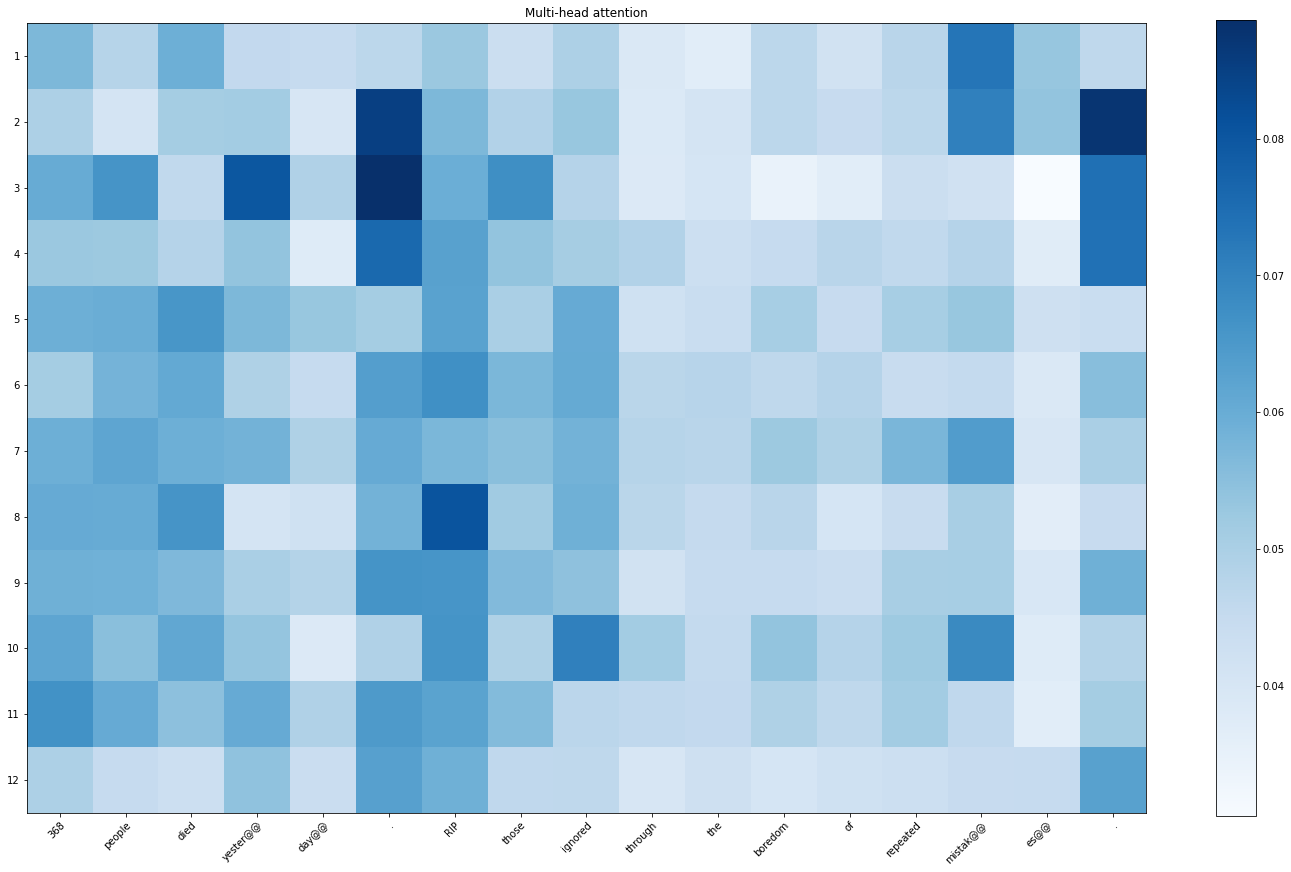

In [14]:
print("sentence = ", sentence)
print("the prediction is: ", pred)
visualisation(weight, token)

In [15]:
sentence = 'it was an amazing performance'
pred, weight, token = sent_pred(sentence, tokenizer)

Tokenize the first sentence:
 ['[@@', 'CL@@', 'S@@', ']', 'it', 'was', 'an', 'amazing', 'performance', '[SEP]']
Index numbers of the first sentence:
 [61658, 6411, 381, 317, 18, 38, 74, 416, 1896, 3]


sentence =  it was an amazing performance
the prediction is:  2


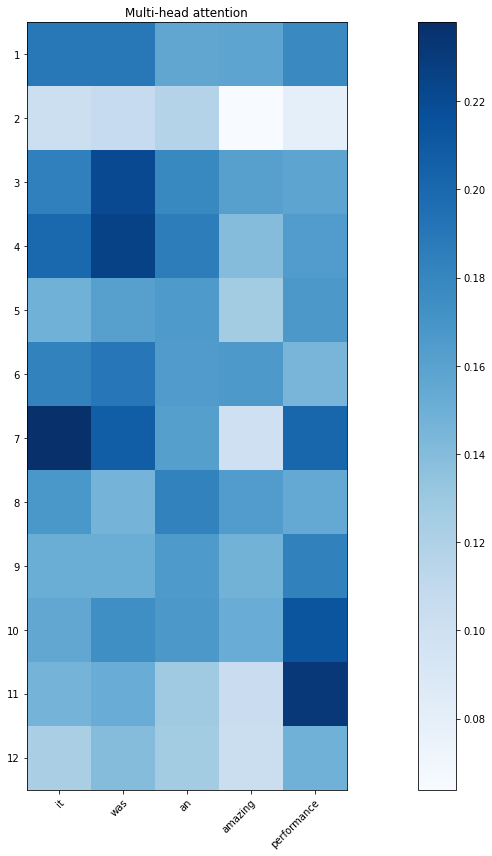

In [16]:
print("sentence = ", sentence)
print("the prediction is: ", pred)
visualisation(weight, token)

In [17]:
sentence = ' \n\nWhat have we become when our boredom means that 368 people die and no one cares. \n\nBut we are free of the heinous mask. \n\nThe UK is full of selfishness. #CovidIsntOver'
pred, weight, token = sent_pred(sentence, tokenizer)

Tokenize the first sentence:
 ['[@@', 'CL@@', 'S@@', ']', 'What', 'have', 'we', 'become', 'when', 'our', 'boredom', 'means', 'that', '368', 'people', 'die', 'and', 'no', 'one', 'car@@', 'es@@', '.', 'But', 'we', 'are', 'free', 'of', 'the', 'heinous', 'mask@@', '.', 'The', 'UK', 'is', 'full', 'of', 'selfish@@', 'ness@@', '.', '#Covid@@', 'Is@@', 'nt@@', 'Over', '[SEP]']
Index numbers of the first sentence:
 [61658, 6411, 381, 317, 165, 36, 54, 870, 64, 123, 17944, 709, 25, 49030, 83, 668, 13, 80, 63, 1741, 783, 4, 192, 54, 41, 336, 15, 6, 52762, 61163, 4, 47, 922, 17, 547, 15, 62507, 16571, 4, 60605, 3166, 11843, 1773, 3]


sentence =   

What have we become when our boredom means that 368 people die and no one cares. 

But we are free of the heinous mask. 

The UK is full of selfishness. #CovidIsntOver
the prediction is:  0


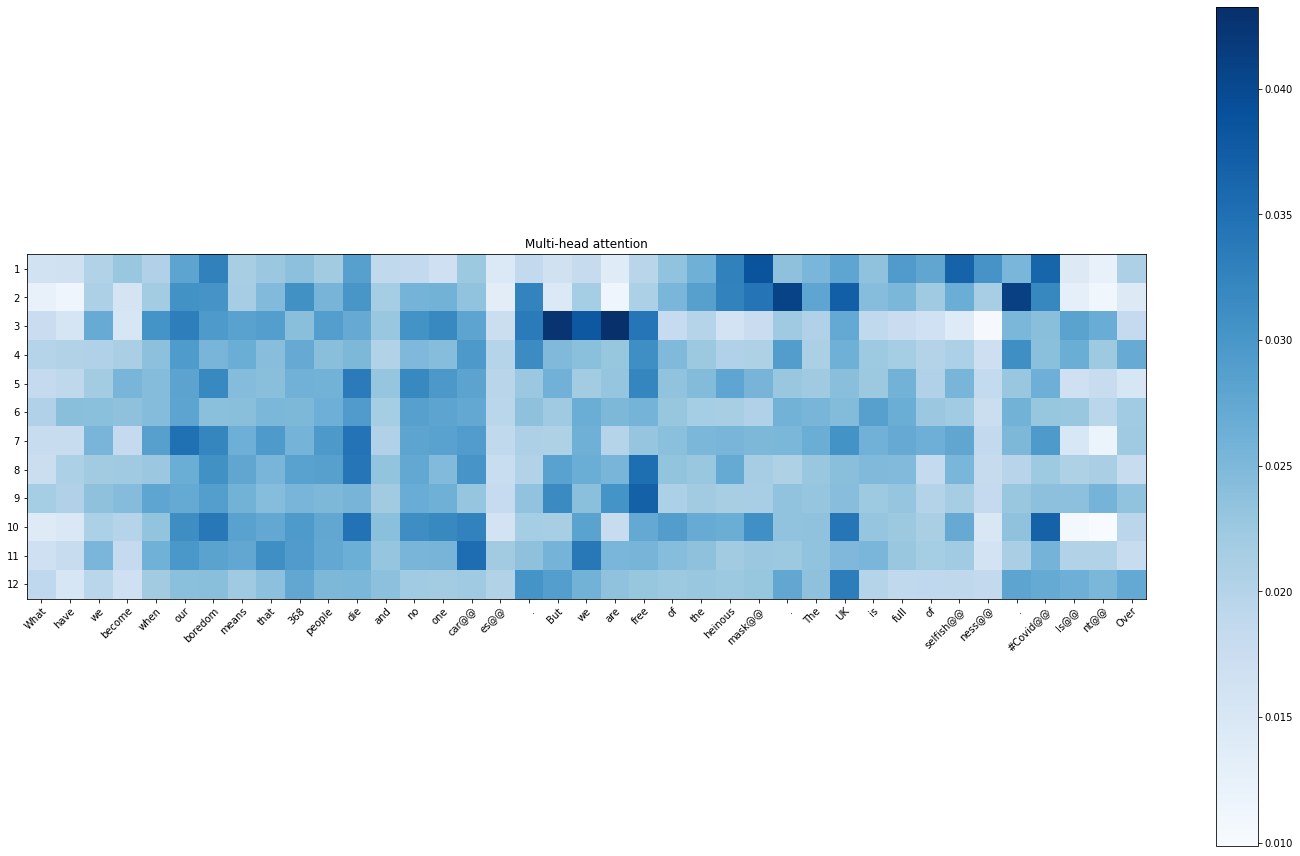

In [18]:
print("sentence = ", sentence)
print("the prediction is: ", pred)
visualisation(weight, token)

In [19]:
sentence = "Triple vaxxed. Got COVID. Not in ICU. Thank you, vaccination! #VaccinesWork https://t.co/c0ldCCnn7s"
pred, weight, token = sent_pred(sentence, tokenizer)

Tokenize the first sentence:
 ['[@@', 'CL@@', 'S@@', ']', 'Triple', 'va@@', 'xx@@', 'ed@@', '.', 'Got', 'CO@@', 'VID@@', '.', 'Not', 'in', 'IC@@', 'U@@', '.', 'Thank', 'you@@', ',', 'vacc@@', 'in@@', 'ation@@', '!', '#V@@', 'acc@@', 'ines@@', 'Work', 'htt@@', 'ps@@', '://@@', 't.co/@@', 'c@@', '0@@', 'ld@@', 'CC@@', 'nn@@', '7s', '[SEP]']
Index numbers of the first sentence:
 [61658, 6411, 381, 317, 13162, 6124, 4912, 1250, 4, 928, 2691, 14107, 4, 319, 16, 2965, 684, 4, 396, 3805, 7, 45458, 520, 4359, 12, 2863, 6530, 17777, 2183, 62060, 8798, 3, 11412, 715, 1162, 10632, 6860, 10022, 26966, 3]


sentence =  Triple vaxxed. Got COVID. Not in ICU. Thank you, vaccination! #VaccinesWork https://t.co/c0ldCCnn7s
the prediction is:  2


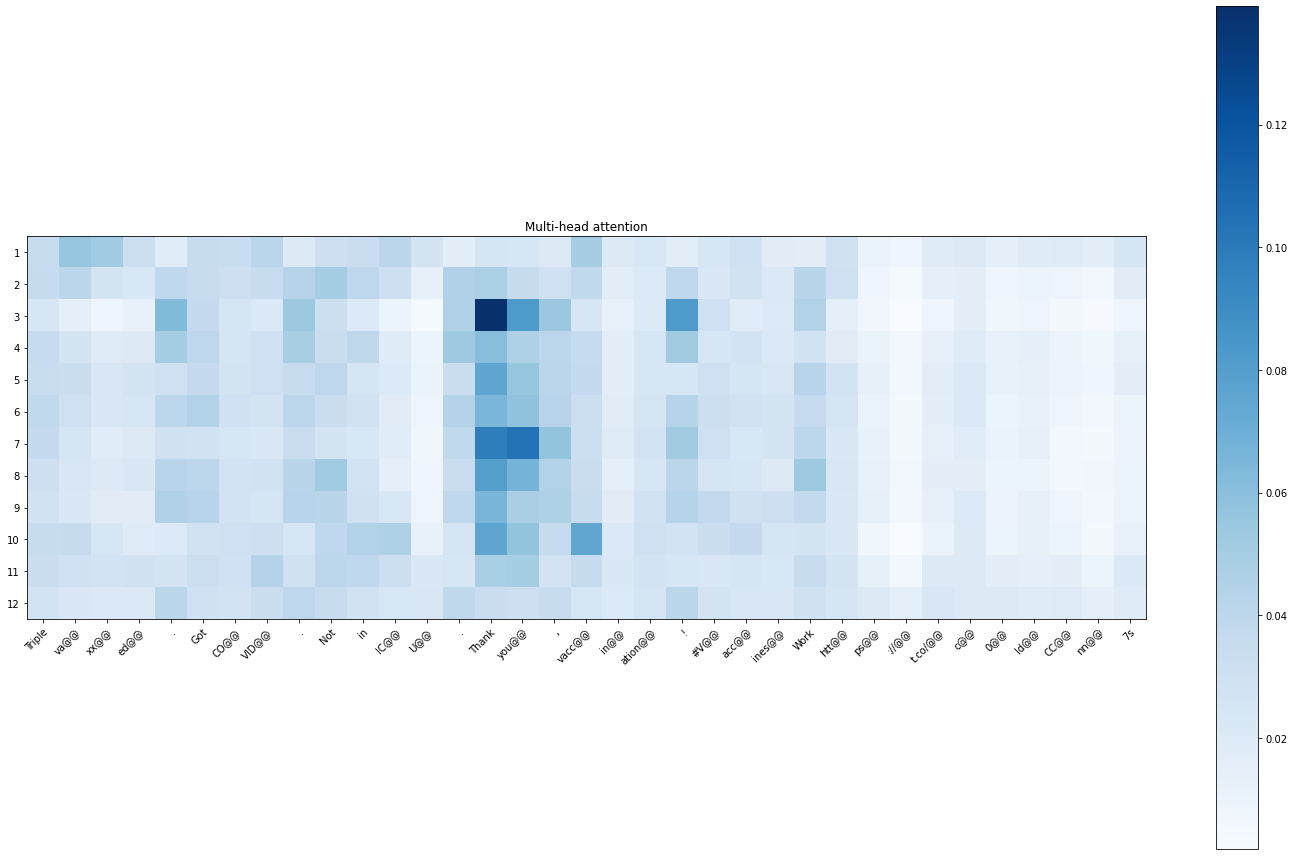

In [20]:
print("sentence = ", sentence)
print("the prediction is: ", pred)
visualisation(weight, token)

In [21]:
sentence = "Dozens and dozens and dozens of young sportspeople dying of heart related issues https://t.co/JZDZsYkDAw #VaccineSideEffects #death"
pred, weight, token = sent_pred(sentence, tokenizer)

Tokenize the first sentence:
 ['[@@', 'CL@@', 'S@@', ']', 'Dozens', 'and', 'dozens', 'and', 'dozens', 'of', 'young', 'sport@@', 'spe@@', 'ople', 'dying', 'of', 'heart', 'related', 'issues', 'htt@@', 'ps@@', '://@@', 't.co/@@', 'J@@', 'ZD@@', 'Z@@', 's@@', 'Y@@', 'k@@', 'DA@@', 'w', '#V@@', 'acc@@', 'ine@@', 'Side@@', 'Effects', '#@@', 'death', '[SEP]']
Index numbers of the first sentence:
 [61658, 6411, 381, 317, 37154, 13, 19116, 13, 19116, 15, 859, 14508, 34344, 43649, 2000, 15, 398, 2857, 1494, 62060, 8798, 3, 11412, 611, 54307, 767, 423, 624, 409, 4049, 293, 2863, 6530, 3800, 22058, 23066, 85, 983, 3]


sentence =  Dozens and dozens and dozens of young sportspeople dying of heart related issues https://t.co/JZDZsYkDAw #VaccineSideEffects #death
the prediction is:  0


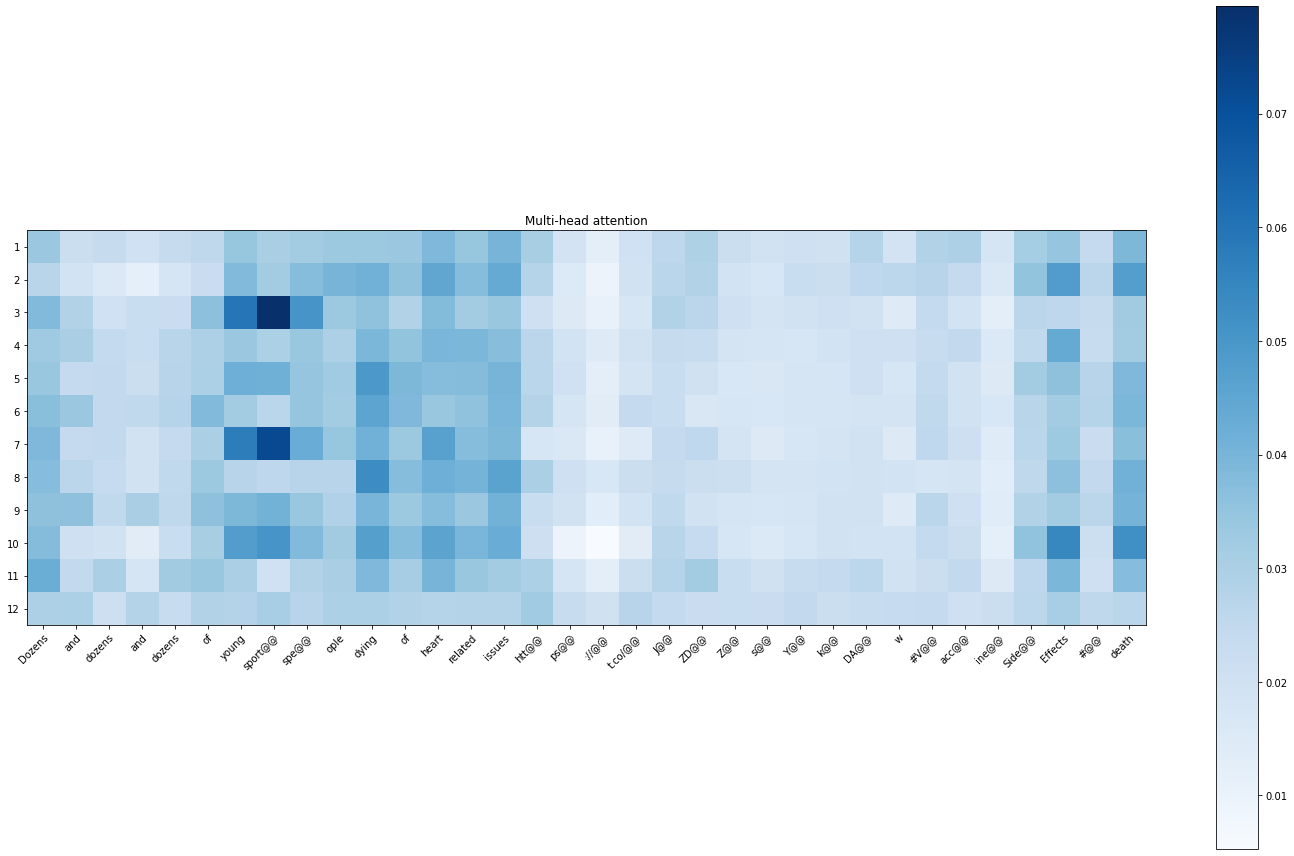

In [22]:
print("sentence = ", sentence)
print("the prediction is: ", pred)
visualisation(weight, token)

In [23]:
sentence = "Good morning friends!  I have a question. No judgement, I promise.  Are you still wearing your mask when indoors shopping, or at the mall?  #Covid #Masks"
pred, weight, token = sent_pred(sentence, tokenizer)

Tokenize the first sentence:
 ['[@@', 'CL@@', 'S@@', ']', 'Good', 'morning', 'friend@@', 's@@', '!', 'I', 'have', 'a', 'question@@', '.', 'No', 'judg@@', 'ement@@', ',', 'I', 'promis@@', 'e.', 'Are', 'you', 'still', 'wearing', 'your', 'mask', 'when', 'indoors', 'sho@@', 'pping@@', ',', 'or', 'at', 'the', 'mall@@', '?', '#Co@@', 'vid', '#M@@', 'asks', '[SEP]']
Index numbers of the first sentence:
 [61658, 6411, 381, 317, 417, 340, 8918, 423, 12, 8, 36, 11, 25302, 4, 218, 31628, 19731, 7, 8, 44530, 3, 533, 14, 135, 1223, 44, 7146, 64, 25587, 4210, 31106, 7, 72, 35, 6, 55202, 21, 8232, 4759, 1230, 3648, 3]


sentence =  Good morning friends!  I have a question. No judgement, I promise.  Are you still wearing your mask when indoors shopping, or at the mall?  #Covid #Masks
the prediction is:  1


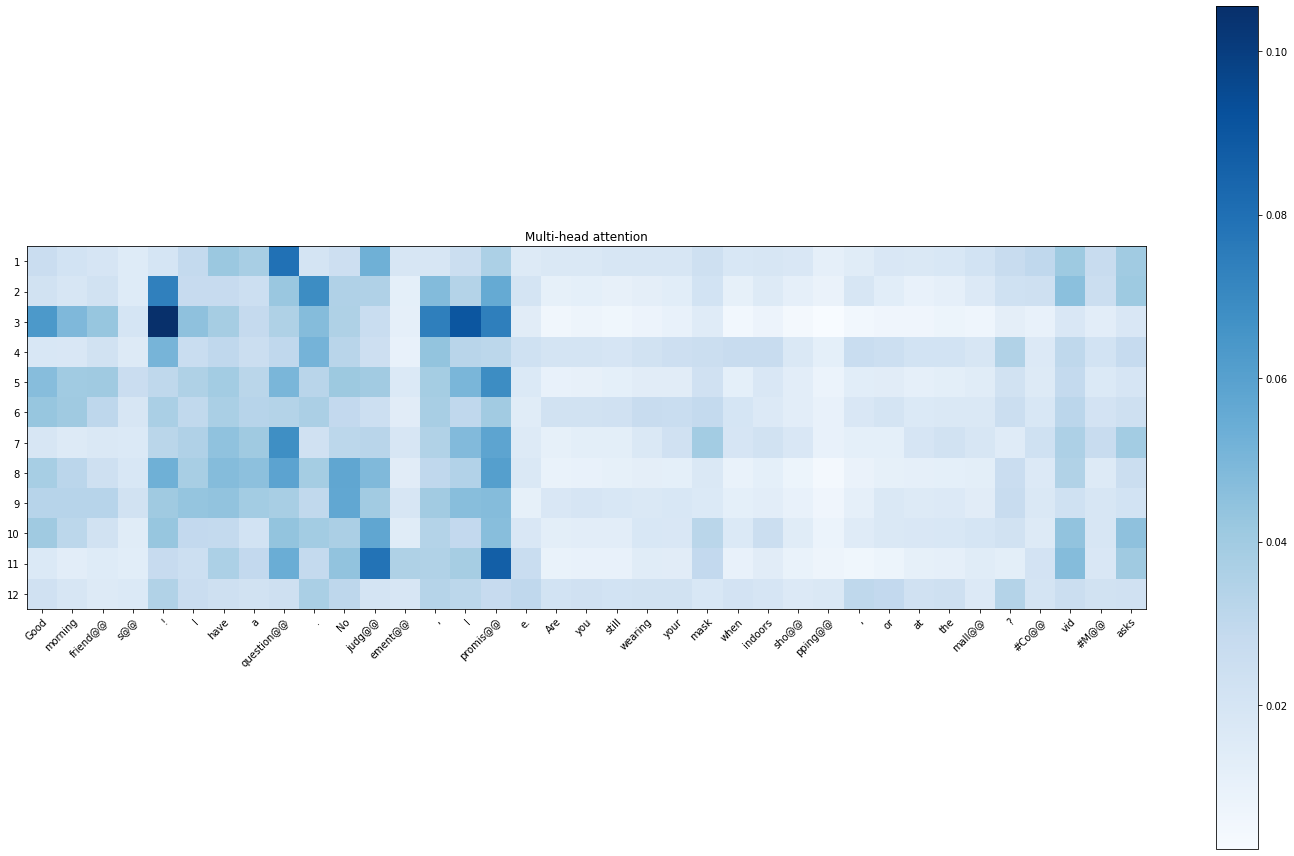

In [24]:
print("sentence = ", sentence)
print("the prediction is: ", pred)
visualisation(weight, token)

In [25]:
sentence = "#votefordout #masks #covid #Dougford #ontario I wish I lived in PEI or Quebec where the premier listened to science https://t.co/uU757dQ1Rw"
pred, weight, token = sent_pred(sentence, tokenizer)

Tokenize the first sentence:
 ['[@@', 'CL@@', 'S@@', ']', '#vote@@', 'ford@@', 'out', '#ma@@', 'sks', '#co@@', 'vid', '#Dou@@', 'g@@', 'ford', '#on@@', 'tario', 'I', 'wish', 'I', 'lived', 'in', 'PE@@', 'I', 'or', 'Quebec', 'where', 'the', 'premier', 'listened', 'to', 'science', 'htt@@', 'ps@@', '://@@', 't.co/@@', 'u@@', 'U@@', '7@@', '57@@', 'd@@', 'Q@@', '1@@', 'R@@', 'w', '[SEP]']
Index numbers of the first sentence:
 [61658, 6411, 381, 317, 33323, 15536, 50, 6884, 41700, 7117, 4759, 60551, 630, 3051, 10073, 60950, 8, 353, 8, 3107, 16, 5943, 8, 72, 15137, 209, 6, 12761, 4571, 9, 2681, 62060, 8798, 3, 11412, 713, 684, 672, 7980, 541, 1554, 1032, 521, 293, 3]


sentence =  #votefordout #masks #covid #Dougford #ontario I wish I lived in PEI or Quebec where the premier listened to science https://t.co/uU757dQ1Rw
the prediction is:  0


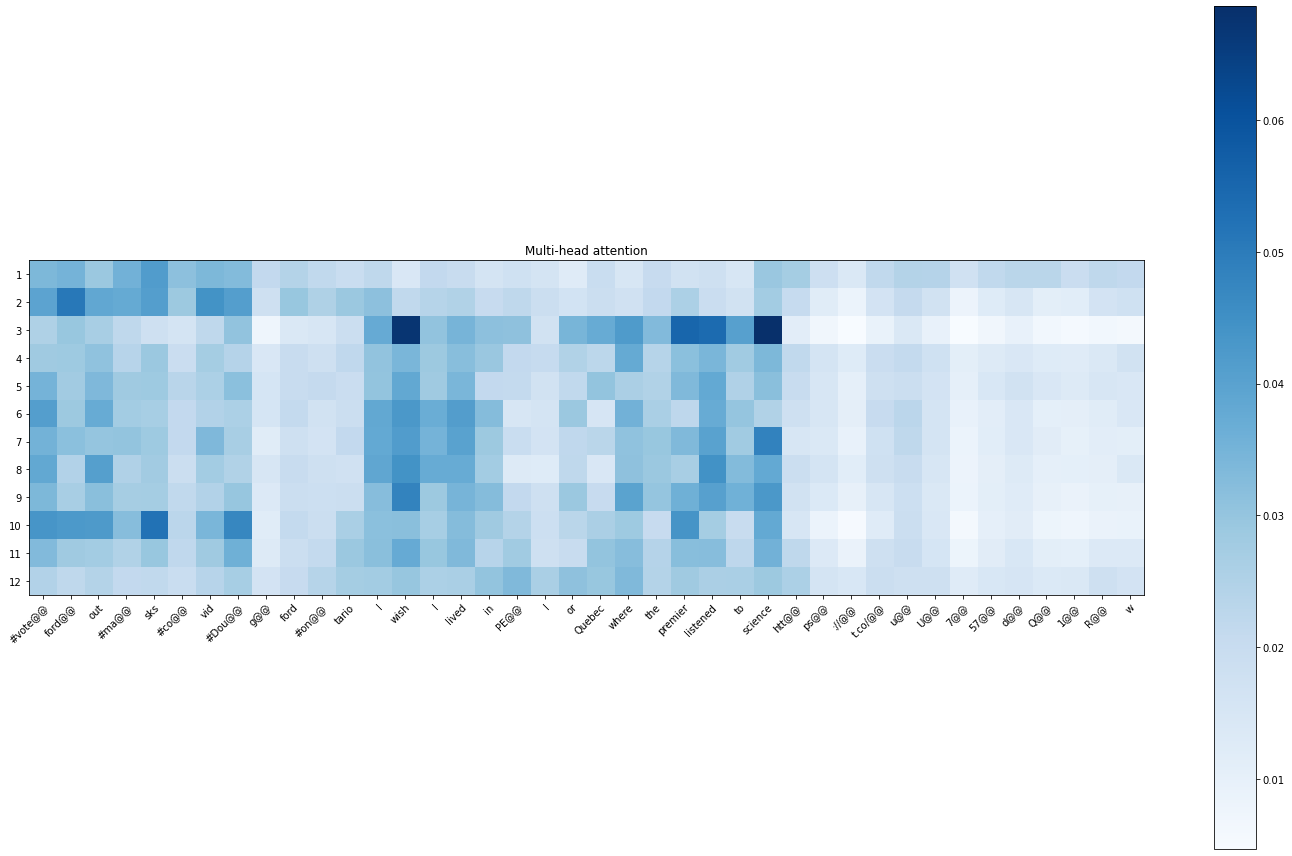

In [26]:
print("sentence = ", sentence)
print("the prediction is: ", pred)
visualisation(weight, token)

In [27]:
# wrong prediction, should be Negative(0)
sentence = "Which science are we following now? Today it's $cience.  #covid #vaccines #masks #money #admityouwerewrong #freedom https://t.co/1QihIkgTn6"
pred, weight, token = sent_pred(sentence, tokenizer)

Tokenize the first sentence:
 ['[@@', 'CL@@', 'S@@', ']', 'Which', 'science', 'are', 'we', 'following', 'now@@', '?', 'Today', 'it@@', "'s", '$@@', 'ci@@', 'ence@@', '.', '#co@@', 'vid', '#v@@', 'acc@@', 'ines', '#ma@@', 'sks', '#money', '#@@', 'adm@@', 'it@@', 'you@@', 'were@@', 'wrong', '#freedom', 'htt@@', 'ps@@', '://@@', 't.co/@@', '1@@', 'Q@@', 'i@@', 'h@@', 'Ik@@', 'g@@', 'T@@', 'n@@', '6', '[SEP]']
Index numbers of the first sentence:
 [61658, 6411, 381, 317, 1918, 2681, 41, 54, 676, 12233, 21, 643, 987, 20, 3, 4765, 11725, 4, 7117, 4759, 6615, 6530, 3972, 6884, 41700, 22469, 85, 23590, 987, 3805, 35622, 415, 59282, 62060, 8798, 3, 11412, 1032, 1554, 510, 650, 37413, 630, 414, 608, 339, 3]


sentence =  Which science are we following now? Today it's $cience.  #covid #vaccines #masks #money #admityouwerewrong #freedom https://t.co/1QihIkgTn6
the prediction is:  1


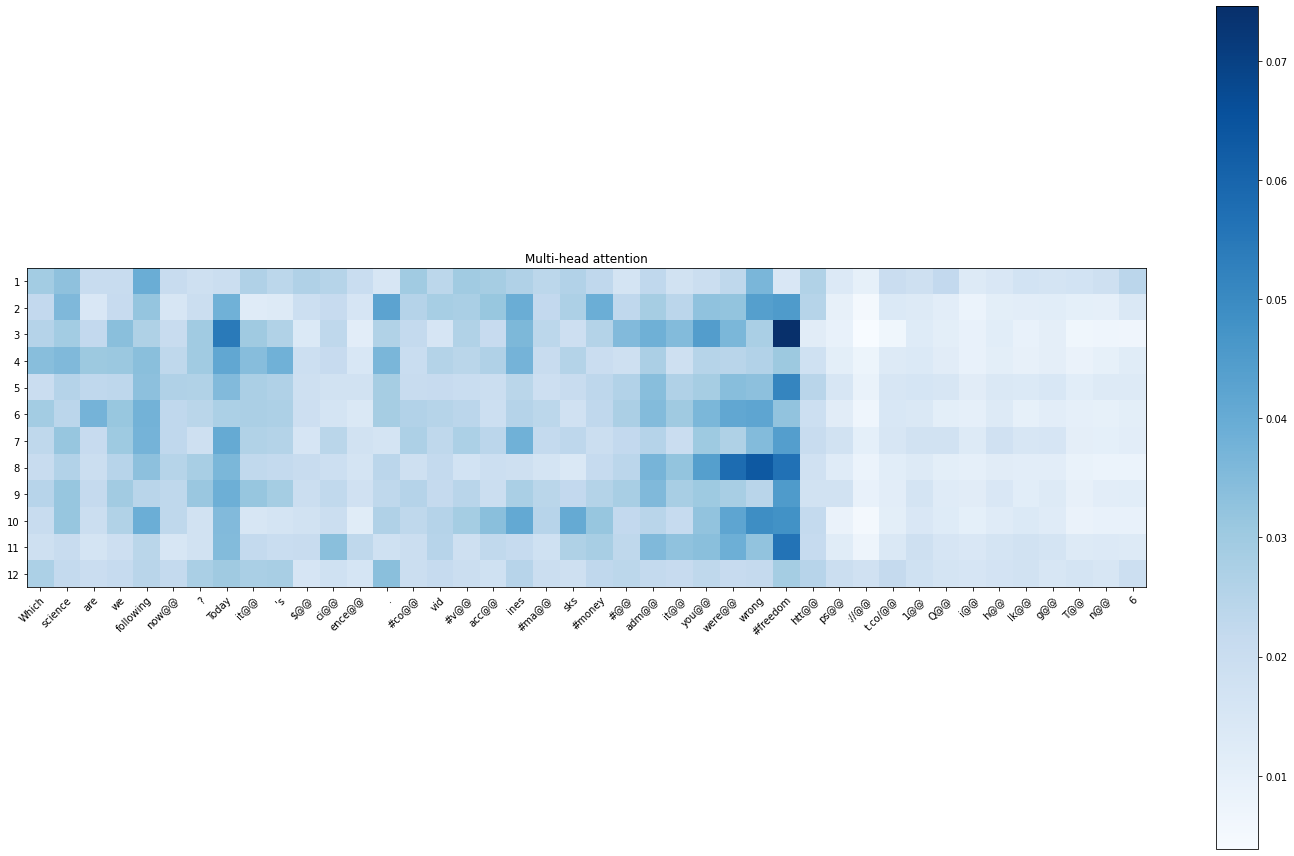

In [28]:
print("sentence = ", sentence)
print("the prediction is: ", pred)
visualisation(weight, token)